# Skin Lesion Classification — Transfer Learning template
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```
If your dataset is packaged differently, adapt `train_dir` / `val_dir` variables below.

This notebook was autogenerated to match SE4050 assignment requirements (4 different model notebooks will be provided).
\n\n**Model:** MobileNetV3-Large

In [5]:
# Environment & imports
# Install PyTorch with CUDA support (run this cell first if CUDA is not available)
# Your system has CUDA 12.7, so use cu124 (compatible with CUDA 12.x):
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Alternative for CUDA 12.1:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install other packages
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.models import MobileNet_V3_Large_Weights

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Force GPU usage
if not torch.cuda.is_available():
    print("CUDA not available. Installing CPU version of PyTorch...")
    # Install CPU version if GPU not available
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    device = torch.device("cpu")
    print("Using CPU. To use GPU, install CUDA and PyTorch with CUDA support.")
else:
    device = torch.device("cuda")
    print("Device:", device)
    print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "N/A")

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Device: cuda
CUDA version: 12.4
Note: you may need to restart the kernel to use updated packages.
Device: cuda
CUDA version: 12.4


In [6]:
# Paths (change these to your dataset locations)
# Download and extract your dataset folders locally, then set the paths below:
train_dir = r"D:\archive\train"  # Example local path
val_dir   = r"D:\archive\val"    # Example local path

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [7]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [8]:
# MobileNetV3 Large (pretrained)
try:
    model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    # Correctly identify the input features for the classifier
    num_ftrs = model.classifier[-1].in_features  # Access the last layer of the classifier
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # Fallback for older torchvision versions or different model structures
    model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    # Attempt to access the in_features from the first layer if the above fails
    try:
        num_ftrs = model.classifier[0].in_features
        model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    except Exception as e_fallback:
        print(f"Could not adapt classifier automatically: {e_fallback}")
        print("Please check the model's classifier structure and adapt the code manually.")

model = model.to(device)

In [9]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 30  # change as needed


In [10]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [11]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="MobileNetV3-Large")


Epoch 1/30


100%|██████████| 333/333 [00:53<00:00,  6.19it/s]


train Loss: 1.1199 Acc: 0.5541 F1: 0.5366


100%|██████████| 42/42 [00:06<00:00,  6.26it/s]



val Loss: 0.6799 Acc: 0.7430 F1: 0.7518
------------------------------
Epoch 2/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.6491 Acc: 0.7230 F1: 0.7043


100%|██████████| 42/42 [00:06<00:00,  6.21it/s]



val Loss: 0.4578 Acc: 0.8297 F1: 0.8063
------------------------------
Epoch 3/30


100%|██████████| 333/333 [00:52<00:00,  6.35it/s]


train Loss: 0.5124 Acc: 0.7847 F1: 0.7701


100%|██████████| 42/42 [00:06<00:00,  6.13it/s]



val Loss: 0.3234 Acc: 0.8779 F1: 0.8592
------------------------------
Epoch 4/30


100%|██████████| 333/333 [00:52<00:00,  6.39it/s]


train Loss: 0.4460 Acc: 0.8173 F1: 0.8013


100%|██████████| 42/42 [00:06<00:00,  6.05it/s]



val Loss: 0.2899 Acc: 0.8802 F1: 0.8739
------------------------------
Epoch 5/30


100%|██████████| 333/333 [00:52<00:00,  6.36it/s]


train Loss: 0.3715 Acc: 0.8449 F1: 0.8343


100%|██████████| 42/42 [00:06<00:00,  6.10it/s]



val Loss: 0.2393 Acc: 0.9141 F1: 0.9016
------------------------------
Epoch 6/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.3563 Acc: 0.8536 F1: 0.8391


100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


val Loss: 0.2350 Acc: 0.9096 F1: 0.8995
------------------------------
Epoch 7/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.3225 Acc: 0.8661 F1: 0.8567


100%|██████████| 42/42 [00:06<00:00,  6.16it/s]



val Loss: 0.1985 Acc: 0.9209 F1: 0.9130
------------------------------
Epoch 8/30


100%|██████████| 333/333 [00:52<00:00,  6.40it/s]


train Loss: 0.3063 Acc: 0.8812 F1: 0.8696


100%|██████████| 42/42 [00:06<00:00,  6.33it/s]


val Loss: 0.2056 Acc: 0.9254 F1: 0.9004
------------------------------
Epoch 9/30


100%|██████████| 333/333 [00:51<00:00,  6.43it/s]


train Loss: 0.2832 Acc: 0.8899 F1: 0.8729


100%|██████████| 42/42 [00:06<00:00,  6.18it/s]


val Loss: 0.2112 Acc: 0.9292 F1: 0.8937
------------------------------
Epoch 10/30


100%|██████████| 333/333 [00:51<00:00,  6.43it/s]


train Loss: 0.2793 Acc: 0.8943 F1: 0.8813


100%|██████████| 42/42 [00:06<00:00,  6.18it/s]



val Loss: 0.1572 Acc: 0.9405 F1: 0.9261
------------------------------
Epoch 11/30


100%|██████████| 333/333 [00:51<00:00,  6.44it/s]


train Loss: 0.2424 Acc: 0.9005 F1: 0.8937


100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


val Loss: 0.1518 Acc: 0.9450 F1: 0.9191
------------------------------
Epoch 12/30


100%|██████████| 333/333 [00:51<00:00,  6.45it/s]


train Loss: 0.2381 Acc: 0.9065 F1: 0.8971


100%|██████████| 42/42 [00:06<00:00,  6.25it/s]


val Loss: 0.1881 Acc: 0.9337 F1: 0.9144
------------------------------
Epoch 13/30


100%|██████████| 333/333 [00:51<00:00,  6.42it/s]


train Loss: 0.2180 Acc: 0.9132 F1: 0.9020


100%|██████████| 42/42 [00:06<00:00,  6.26it/s]



val Loss: 0.1444 Acc: 0.9503 F1: 0.9316
------------------------------
Epoch 14/30


100%|██████████| 333/333 [00:51<00:00,  6.45it/s]


train Loss: 0.2282 Acc: 0.9110 F1: 0.9013


100%|██████████| 42/42 [00:06<00:00,  6.13it/s]


val Loss: 0.1346 Acc: 0.9495 F1: 0.9216
------------------------------
Epoch 15/30


100%|██████████| 333/333 [00:51<00:00,  6.45it/s]



train Loss: 0.2002 Acc: 0.9180 F1: 0.9103


100%|██████████| 42/42 [00:06<00:00,  6.33it/s]



val Loss: 0.1167 Acc: 0.9631 F1: 0.9445
------------------------------
Epoch 16/30


100%|██████████| 333/333 [00:51<00:00,  6.46it/s]


train Loss: 0.1895 Acc: 0.9256 F1: 0.9183


100%|██████████| 42/42 [00:06<00:00,  6.25it/s]



val Loss: 0.1162 Acc: 0.9623 F1: 0.9542
------------------------------
Epoch 17/30


100%|██████████| 333/333 [00:51<00:00,  6.44it/s]


train Loss: 0.2006 Acc: 0.9254 F1: 0.9151


100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


val Loss: 0.1491 Acc: 0.9563 F1: 0.9443
------------------------------
Epoch 18/30


100%|██████████| 333/333 [00:51<00:00,  6.45it/s]


train Loss: 0.1859 Acc: 0.9252 F1: 0.9178


100%|██████████| 42/42 [00:06<00:00,  6.27it/s]


val Loss: 0.1189 Acc: 0.9601 F1: 0.9501
------------------------------
Epoch 19/30


100%|██████████| 333/333 [00:51<00:00,  6.45it/s]


train Loss: 0.1839 Acc: 0.9254 F1: 0.9156


100%|██████████| 42/42 [00:06<00:00,  6.28it/s]


val Loss: 0.1277 Acc: 0.9616 F1: 0.9461
------------------------------
Epoch 20/30


100%|██████████| 333/333 [00:51<00:00,  6.44it/s]


train Loss: 0.1686 Acc: 0.9354 F1: 0.9281


100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


val Loss: 0.1263 Acc: 0.9586 F1: 0.9364
------------------------------
Epoch 21/30


100%|██████████| 333/333 [00:51<00:00,  6.45it/s]


train Loss: 0.1645 Acc: 0.9372 F1: 0.9327


100%|██████████| 42/42 [00:06<00:00,  6.11it/s]


val Loss: 0.1704 Acc: 0.9472 F1: 0.9342
------------------------------
Epoch 22/30


100%|██████████| 333/333 [00:51<00:00,  6.43it/s]


train Loss: 0.1766 Acc: 0.9342 F1: 0.9284


100%|██████████| 42/42 [00:06<00:00,  6.11it/s]



val Loss: 0.1183 Acc: 0.9714 F1: 0.9543
------------------------------
Epoch 23/30


100%|██████████| 333/333 [00:51<00:00,  6.44it/s]


train Loss: 0.1493 Acc: 0.9393 F1: 0.9361


100%|██████████| 42/42 [00:06<00:00,  6.27it/s]


val Loss: 0.1505 Acc: 0.9578 F1: 0.9354
------------------------------
Epoch 24/30


100%|██████████| 333/333 [00:51<00:00,  6.44it/s]


train Loss: 0.1663 Acc: 0.9337 F1: 0.9248


100%|██████████| 42/42 [00:06<00:00,  6.17it/s]



val Loss: 0.1194 Acc: 0.9661 F1: 0.9585
------------------------------
Epoch 25/30


100%|██████████| 333/333 [00:51<00:00,  6.43it/s]


train Loss: 0.1512 Acc: 0.9375 F1: 0.9320


100%|██████████| 42/42 [00:06<00:00,  6.27it/s]


val Loss: 0.1095 Acc: 0.9683 F1: 0.9582
------------------------------
Epoch 26/30


100%|██████████| 333/333 [00:52<00:00,  6.33it/s]


train Loss: 0.1400 Acc: 0.9387 F1: 0.9360


100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


val Loss: 0.1322 Acc: 0.9616 F1: 0.9463
------------------------------
Epoch 27/30


100%|██████████| 333/333 [00:52<00:00,  6.39it/s]



train Loss: 0.1369 Acc: 0.9434 F1: 0.9404


100%|██████████| 42/42 [00:06<00:00,  6.18it/s]


val Loss: 0.1334 Acc: 0.9646 F1: 0.9417
------------------------------
Epoch 28/30


100%|██████████| 333/333 [00:51<00:00,  6.41it/s]


train Loss: 0.1467 Acc: 0.9453 F1: 0.9405


100%|██████████| 42/42 [00:06<00:00,  6.25it/s]



val Loss: 0.0908 Acc: 0.9721 F1: 0.9617
------------------------------
Epoch 29/30


100%|██████████| 333/333 [00:51<00:00,  6.44it/s]


train Loss: 0.1230 Acc: 0.9467 F1: 0.9464


100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


val Loss: 0.1270 Acc: 0.9616 F1: 0.9437
------------------------------
Epoch 30/30


100%|██████████| 333/333 [00:52<00:00,  6.32it/s]


train Loss: 0.1451 Acc: 0.9436 F1: 0.9398


100%|██████████| 42/42 [00:06<00:00,  6.10it/s]

val Loss: 0.0963 Acc: 0.9736 F1: 0.9643
------------------------------
Training complete in 29m 25s
Best val F1: 0.9643


In [12]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


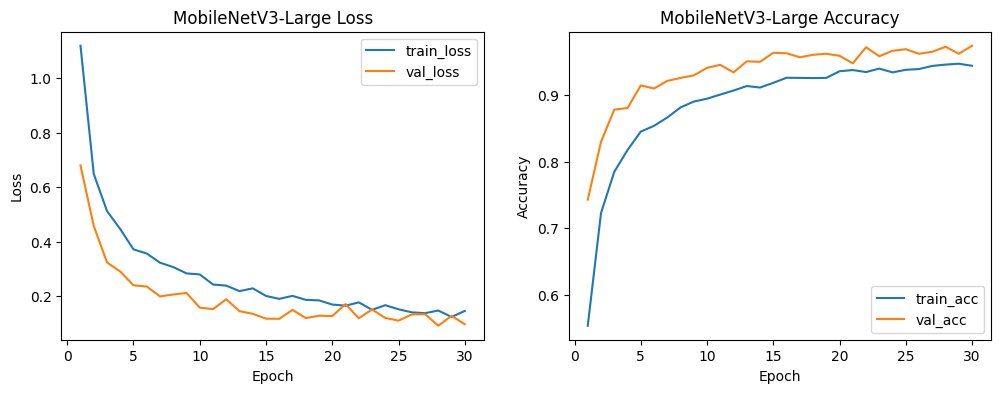

In [13]:
plot_history(history, model_name="MobileNetV3-Large")


In [14]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    
    # Fix sklearn warnings by setting zero_division parameter
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

In [15]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.88      0.93      0.90        86
             Chickenpox       0.96      0.96      0.96       112
                 Cowpox       0.99      0.98      0.98        99
         Dermatofibroma       0.96      0.96      0.96        23
                   HFMD       0.97      1.00      0.99       241
                Healthy       0.99      0.98      0.99       171
                Measles       1.00      1.00      1.00        82
              Monkeypox       0.99      0.98      0.98       426
Squamous cell carcinoma       0.90      0.85      0.88        62
       Vascular lesions       1.00      1.00      1.00        25

               accuracy                           0.97      1327
              macro avg       0.96      0.96      0.96      1327
           weighted avg       0.97      0.97      0.97      1327

Confusion matrix:
 [[ 80   0   0   0   0   0   0   0   6   0]
 [  1 108   0   0   0   1

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 1337

Test set class distribution:
  Actinic keratoses: 88
  Chickenpox: 113
  Cowpox: 99
  Dermatofibroma: 25
  HFMD: 242
  Healthy: 171
  Measles: 83
  Monkeypox: 426
  Squamous cell carcinoma: 64
  Vascular lesions: 26

✅ Loaded checkpoint: MobileNetV3-Large_best.pth

TEST SET EVALUATION RESULTS
Overall Accuracy: 0.970
F1 Score (Macro): 0.952
F1 Score (Weighted): 0.970

Detailed Classification Report:
                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.89      0.89        88
             Chickenpox       0.96      0.96      0.96       113
                 Cowpox       0.99      0.97      0.98        99
         Dermatofibroma       0.91      0.84      0.88        25
               

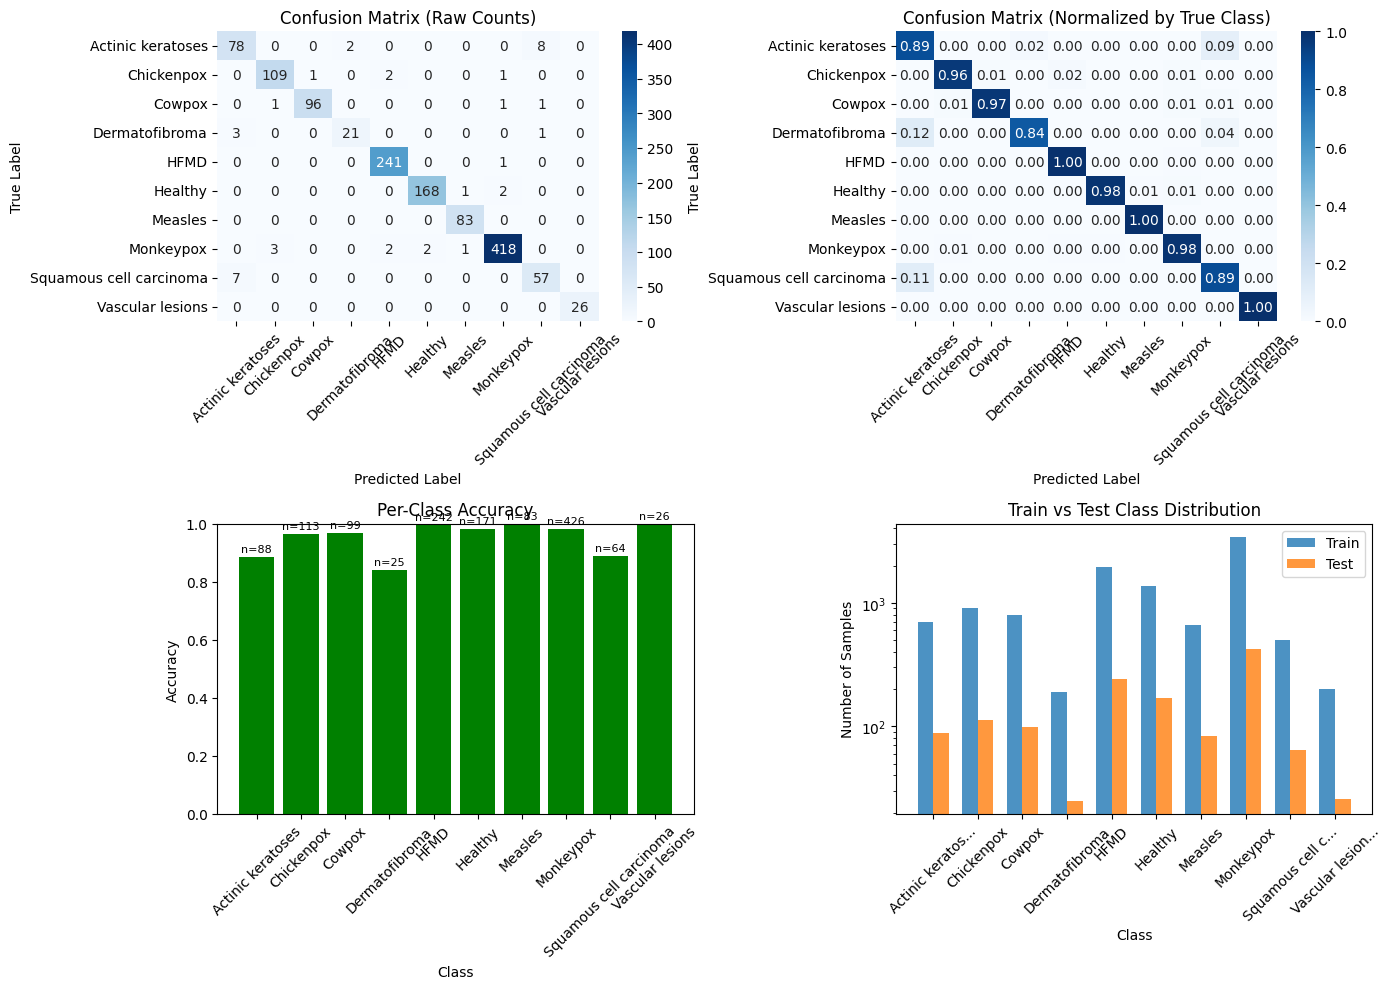


DIAGNOSTIC INFORMATION

Classes with poor performance (accuracy < 0.1):

Model's prediction bias (most frequently predicted classes):
  Monkeypox: 423 predictions (31.6%)
  HFMD: 245 predictions (18.3%)
  Healthy: 170 predictions (12.7%)
  Chickenpox: 113 predictions (8.5%)
  Cowpox: 97 predictions (7.3%)

Suggestions for improvement:
1. The model appears to be heavily biased toward certain classes (especially HFMD)
2. Consider data augmentation or resampling for underrepresented classes
3. Adjust class weights more aggressively
4. Consider using focal loss instead of weighted cross-entropy
5. Ensure test set class distribution matches expected real-world distribution

✅ Saved detailed predictions to: test_predictions_detailed.csv

Misclassification summary:
Total misclassified: 40/1337 (3.0%)
Most common misclassifications:
  Actinic keratoses → Squamous cell carcinoma: 8 cases
  Squamous cell carcinoma → Actinic keratoses: 7 cases
  Monkeypox → Chickenpox: 3 cases
  Dermatofibroma →

In [16]:
# Test Set Evaluation with Improved Error Handling
%pip install pandas seaborn
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# path to test data 
test_dir = r"D:\archive\test"
# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# Check class distribution in test set
test_class_counts = {}
for _, label in test_dataset.samples:
    class_name = test_dataset.classes[label]
    test_class_counts[class_name] = test_class_counts.get(class_name, 0) + 1

print("\nTest set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")

# load best checkpoint (if you saved it during training)
ckpt_path = "MobileNetV3-Large_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print(f"\n✅ Loaded checkpoint: {ckpt_path}")
except Exception as e:
    print(f"⚠️ Checkpoint load failed (using current model): {e}")

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# Calculate metrics with zero_division parameter to fix warnings
print("\n" + "="*50)
print("TEST SET EVALUATION RESULTS")
print("="*50)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Overall Accuracy: {accuracy:.3f}")
print(f"F1 Score (Macro): {f1_macro:.3f}")
print(f"F1 Score (Weighted): {f1_weighted:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Raw Confusion Matrix:")
print(cm)

# Enhanced confusion matrix visualization
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
# Use seaborn for better heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(2, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Class-wise performance analysis
plt.subplot(2, 2, 3)
class_accuracies = []
class_support = []
for i in range(len(class_names)):
    if cm[i].sum() > 0:  # Only if class has samples
        class_acc = cm[i, i] / cm[i].sum()
        class_accuracies.append(class_acc)
        class_support.append(cm[i].sum())
    else:
        class_accuracies.append(0)
        class_support.append(0)

bars = plt.bar(range(len(class_names)), class_accuracies, 
               color=['red' if acc < 0.1 else 'orange' if acc < 0.5 else 'green' 
                      for acc in class_accuracies])
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)

# Add support numbers on bars
for i, (bar, support) in enumerate(zip(bars, class_support)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'n={support}', ha='center', va='bottom', fontsize=8)

# Class distribution comparison
plt.subplot(2, 2, 4)
class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in class_names]
# Get train counts from train_dataset if available
if 'train_dataset' in globals():
    train_class_counts = {}
    for _, label in train_dataset.samples:
        class_name = train_dataset.classes[label]
        train_class_counts[class_name] = train_class_counts.get(class_name, 0) + 1
    train_counts = [train_class_counts.get(class_names[i], 0) for i in range(len(class_names))]
else:
    train_counts = [0] * len(class_names)
test_counts = [test_class_counts.get(class_names[i], 0) for i in range(len(class_names))]

x = np.arange(len(class_names))
width = 0.35
plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.title("Train vs Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(x, class_names_short, rotation=45)
plt.legend()
plt.yscale('log')  # Log scale to better show differences

plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n" + "="*50)
print("DIAGNOSTIC INFORMATION")
print("="*50)

print("\nClasses with poor performance (accuracy < 0.1):")
for i, (class_name, acc, support) in enumerate(zip(class_names, class_accuracies, class_support)):
    if acc < 0.1 and support > 0:
        print(f"  {class_name}: {acc:.3f} accuracy, {support} samples")
    elif support == 0:
        print(f"  {class_name}: No test samples available")

print("\nModel's prediction bias (most frequently predicted classes):")
pred_counts = np.bincount(y_pred, minlength=len(class_names))
for i in np.argsort(pred_counts)[::-1][:5]:  # Top 5 most predicted
    print(f"  {class_names[i]}: {pred_counts[i]} predictions ({pred_counts[i]/len(y_pred)*100:.1f}%)")

print("\nSuggestions for improvement:")
print("1. The model appears to be heavily biased toward certain classes (especially HFMD)")
print("2. Consider data augmentation or resampling for underrepresented classes")
print("3. Adjust class weights more aggressively")
print("4. Consider using focal loss instead of weighted cross-entropy")
print("5. Ensure test set class distribution matches expected real-world distribution")

# Save detailed results
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": [os.path.basename(f) for f in filenames],  # Just filename, not full path
    "true_label": [class_names[i] for i in y_true],
    "pred_label": [class_names[i] for i in y_pred],
    "confidence": [round(float(np.max(p)), 4) for p in probs],
    "correct": [t == p for t, p in zip(y_true, y_pred)]
})

# Add per-class confidence statistics
df.to_csv("test_predictions_detailed.csv", index=False)
print(f"\n✅ Saved detailed predictions to: test_predictions_detailed.csv")

# Summary of misclassifications
print(f"\nMisclassification summary:")
misclassified = df[~df['correct']]
if len(misclassified) > 0:
    print(f"Total misclassified: {len(misclassified)}/{len(df)} ({len(misclassified)/len(df)*100:.1f}%)")
    print("Most common misclassifications:")
    misclass_pairs = misclassified.groupby(['true_label', 'pred_label']).size().sort_values(ascending=False)
    for (true_label, pred_label), count in misclass_pairs.head(10).items():
        print(f"  {true_label} → {pred_label}: {count} cases")
else:
    print("Perfect classification! (This is unlikely - please verify your data)")

<Figure size 1000x600 with 0 Axes>

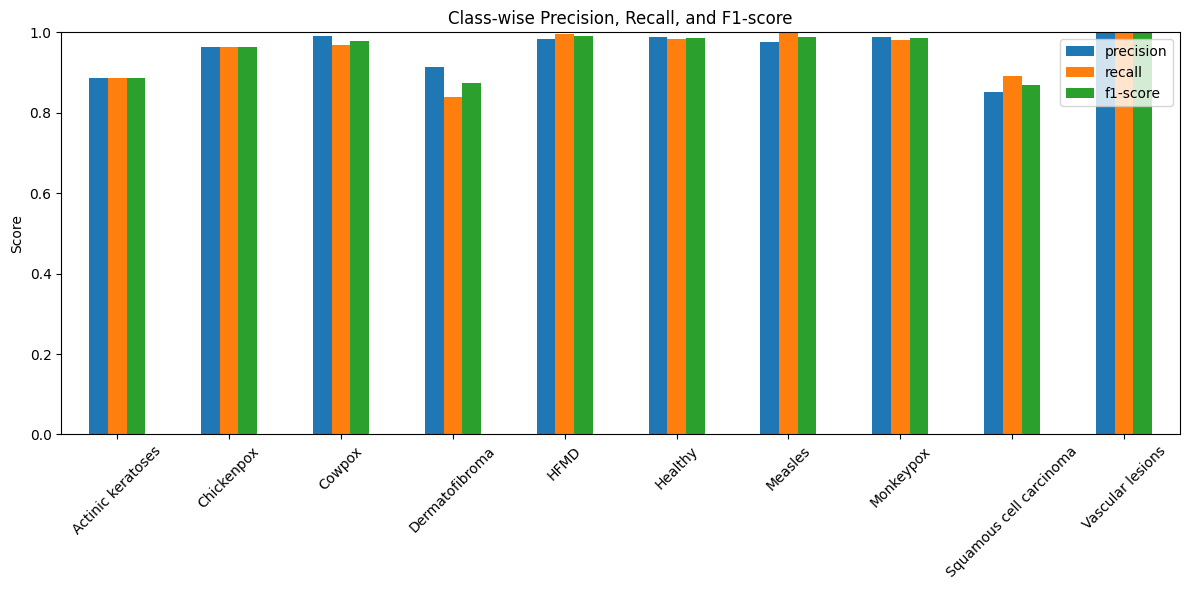

In [18]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Compute report as DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3, :]  # remove avg rows

plt.figure(figsize=(10,6))
df_report[['precision','recall','f1-score']].plot(kind='bar', figsize=(12,6))
plt.title("Class-wise Precision, Recall, and F1-score")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

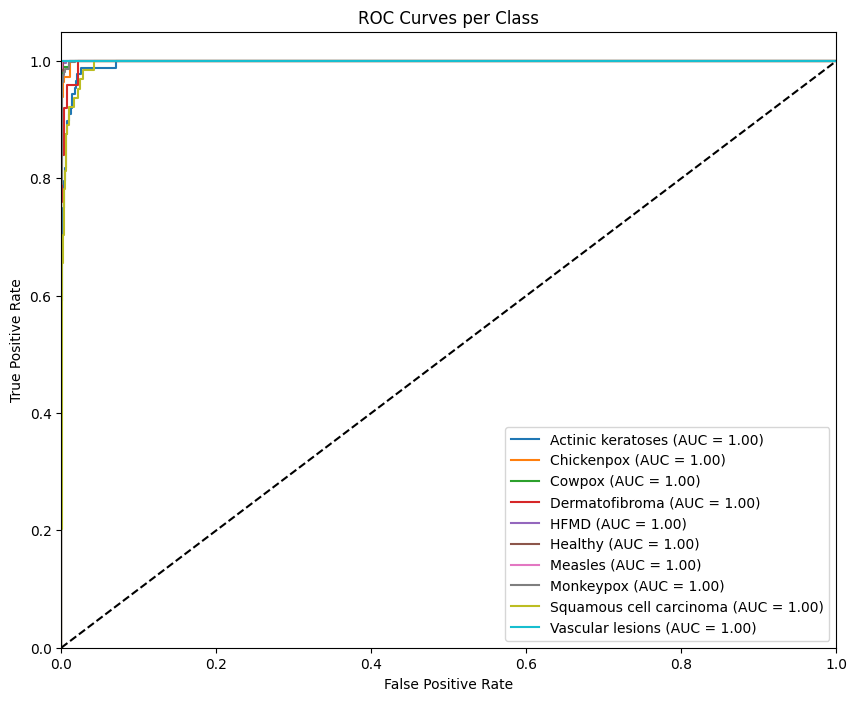

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
y_pred_prob = np.array(probs)  # shape (n_samples, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc="lower right")
plt.show()

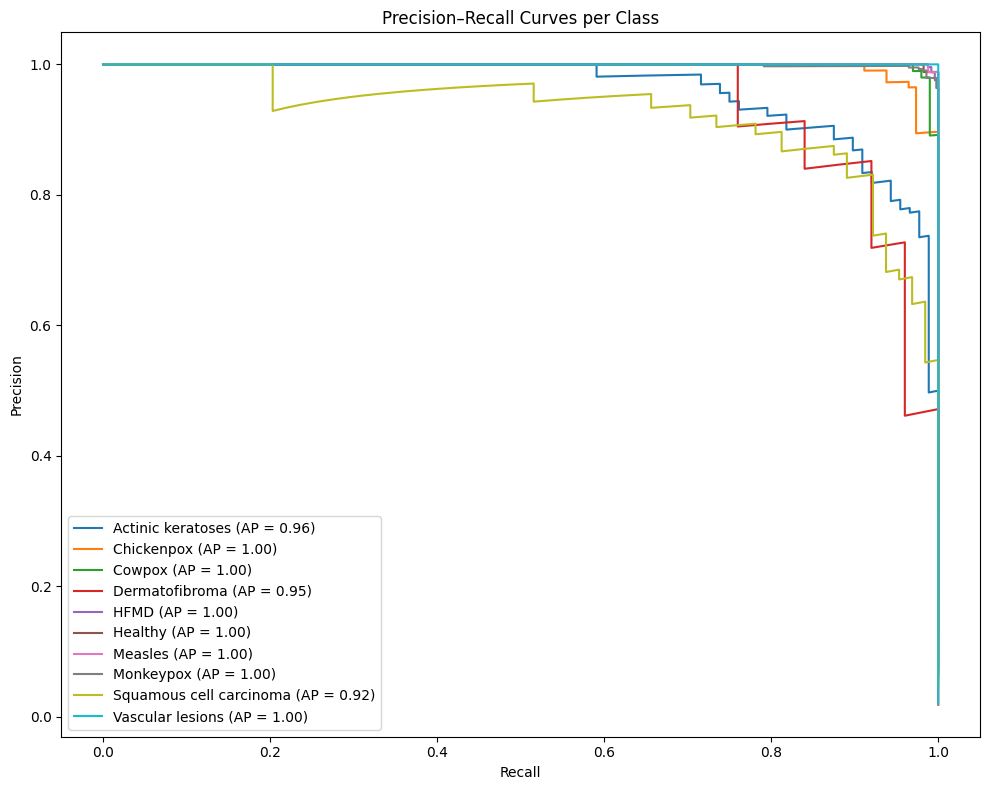

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')

plt.title("Precision–Recall Curves per Class")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
import cv2
from torch.nn import functional as F
from PIL import Image

# Grad-CAM for MobileNetV3 (last conv block)
def gradcam_visualize(model, img_path, target_layer="features"):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    input_tensor = val_transforms(image).unsqueeze(0).to(device)

    grad = None
    fmap = None

    def forward_hook(module, input, output):
        nonlocal fmap
        fmap = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal grad
        grad = grad_out[0]

    # Clear any existing hooks to avoid conflicts
    for module in model.modules():
        if hasattr(module, '_backward_hooks'):
            module._backward_hooks.clear()
        if hasattr(module, '_forward_hooks'):
            module._forward_hooks.clear()
        module._is_full_backward_hook = None

    # Attach hooks to the target layer
    layer = dict([*model.named_modules()])[target_layer]
    forward_handle = layer.register_forward_hook(forward_hook)
    backward_handle = layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    pred = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    output[:, pred].backward()

    # Compute Grad-CAM
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * fmap).sum(dim=1).squeeze()

    # Detach before converting to numpy
    cam = cam.detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (224, 224))

    # Overlay heatmap on original image
    img = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM: {class_names[pred]}")
    plt.axis("off")
    plt.show()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

c:\Users\nethm\miniconda3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


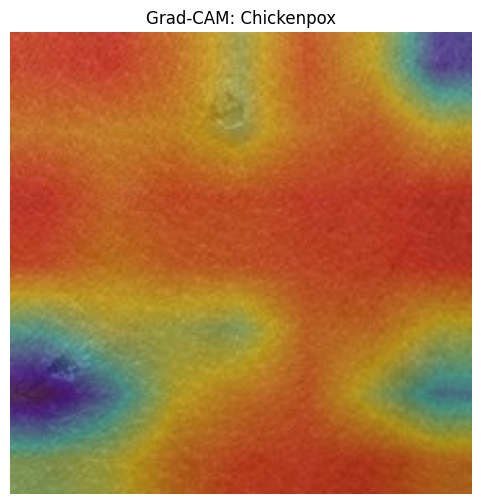

In [22]:
gradcam_visualize(model, r"D:\archive\test\Chickenpox\CHP_02_01_8.jpg")

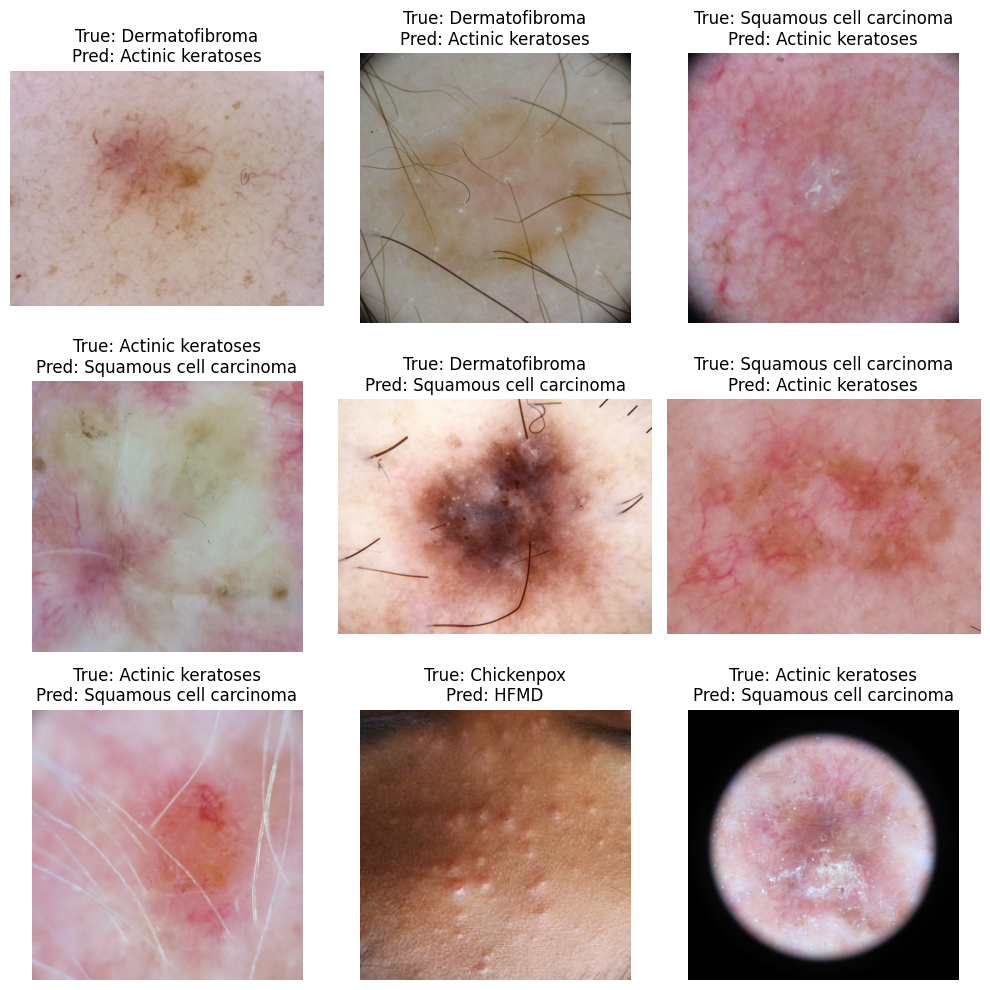

In [23]:
import random

misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
sample_indices = random.sample(misclassified_indices, min(9, len(misclassified_indices)))

plt.figure(figsize=(10,10))
for idx, i in enumerate(sample_indices):
    img_path = test_dataset.samples[i][0]
    img = Image.open(img_path)
    plt.subplot(3,3,idx+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

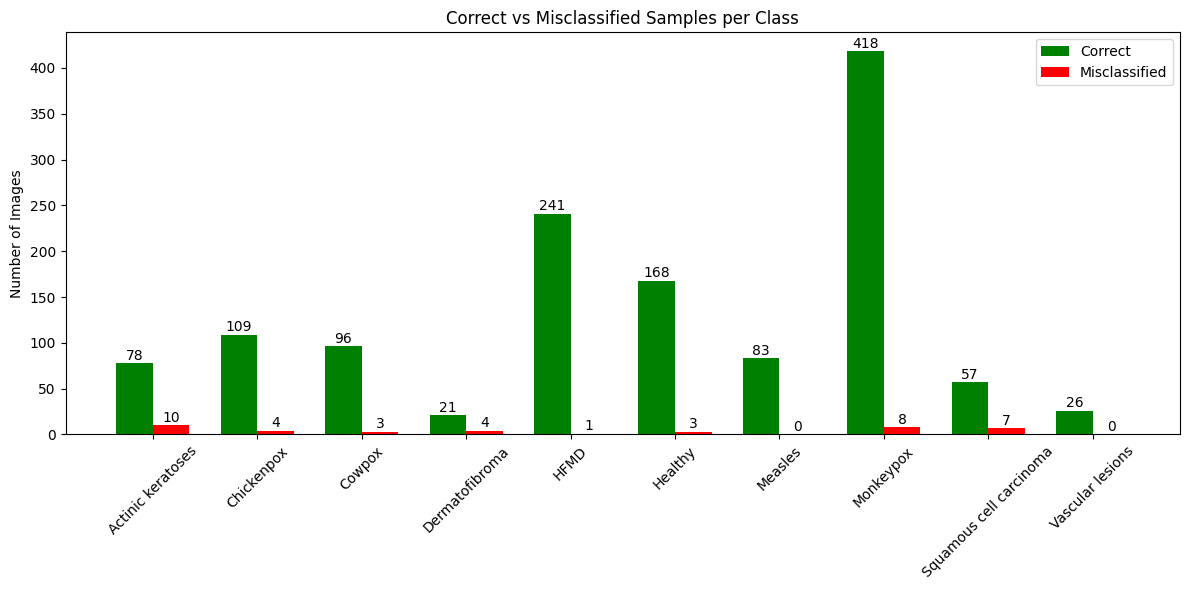

In [24]:
# Total samples per class
total_per_class = np.zeros(len(class_names))
correct_per_class = np.zeros(len(class_names))
misclassified_per_class = np.zeros(len(class_names))

for i, cls_idx in enumerate(y_true):
    total_per_class[cls_idx] += 1
    if y_true[i] == y_pred[i]:
        correct_per_class[cls_idx] += 1
    else:
        misclassified_per_class[cls_idx] += 1

# Plotting
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(12,6))
bars_correct = plt.bar(x - width/2, correct_per_class, width, label='Correct', color='green')
bars_misclassified = plt.bar(x + width/2, misclassified_per_class, width, label='Misclassified', color='red')

# Add counts on top of bars
for bar in bars_correct:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)

for bar in bars_misclassified:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.xticks(x, class_names, rotation=45)
plt.ylabel("Number of Images")
plt.title("Correct vs Misclassified Samples per Class")
plt.legend()
plt.tight_layout()
plt.show()

## Notes and next steps
- Tune learning rates, batch size, augmentation.
- Consider 5-fold cross validation for robustness.
- Use mixed precision (torch.cuda.amp) to speed up training on large GPUs.
- Save final models and record results in a comparison table.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.68244..1.1700488].


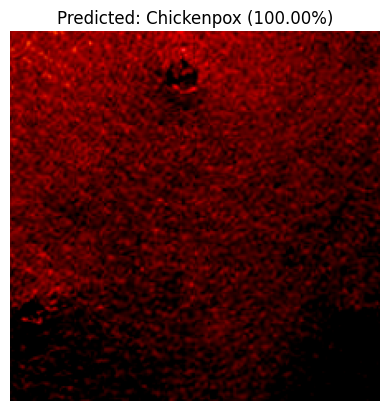

In [25]:
# Load the best model for inference
from PIL import Image
from torchvision.models import MobileNet_V3_Large_Weights
model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(class_names))
model.load_state_dict(torch.load('MobileNetV3-Large_best.pth'))
model = model.to(device)
model.eval()

# Function to predict single image
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
        predicted_label = class_names[predicted.item()]
        confidence = confidence.item()
    return predicted_label, confidence, image.squeeze(0).cpu()

# Example prediction
test_image_path = r"D:\archive\test\Chickenpox\CHP_02_01_8.jpg"  # Replace with actual path
predicted_label, confidence, img_tensor = predict_image(test_image_path, model, val_transforms)

# Display image with prediction
plt.imshow(img_tensor.permute(1,2,0))
plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()